# Problema 3: Comparación de Rendimiento con GLPK/Pyomo

## Se utiliza el código que se realizó para el metodo Simplex estándar

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Simplex:
    def __init__(self, c, A, b):
        self.c = np.array(c, dtype=float)
        self.A = np.array(A, dtype=float)
        self.b = np.array(b, dtype=float)
        self.m, self.n = self.A.shape

    def solve(self):
        # Construcción de la tabla: [A | I | b]
        tableau = np.zeros((self.m + 1, self.n + self.m + 1))
        tableau[:-1, :self.n] = self.A
        tableau[:-1, self.n:self.n + self.m] = np.eye(self.m)
        tableau[:-1, -1] = self.b
        tableau[-1, :self.n] = -self.c

        basic_vars = list(range(self.n, self.n + self.m))
        iterations = 0

        print("=== MÉTODO SIMPLEX ===")
        print("Tabla inicial:")
        self.print_tableau(tableau, basic_vars)

        while np.any(tableau[-1, :-1] < -1e-10):
            entering = np.argmin(tableau[-1, :-1])  # variable entrante

            ratios = []
            for i in range(self.m):
                if tableau[i, entering] > 1e-10:
                    ratios.append((tableau[i, -1] / tableau[i, entering], i))
                else:
                    ratios.append((np.inf, i))

            if all(r[0] == np.inf for r in ratios):
                raise ValueError("Problema ilimitado.")

            leaving_idx = min(ratios)[1]

            pivot = tableau[leaving_idx, entering]
            tableau[leaving_idx] /= pivot

            for i in range(self.m + 1):
                if i != leaving_idx:
                    tableau[i] -= tableau[i, entering] * tableau[leaving_idx]

            basic_vars[leaving_idx] = entering
            iterations += 1

            print(f"\nIteración {iterations}:")
            self.print_tableau(tableau, basic_vars)

        # Extraer solución
        solution = np.zeros(self.n)
        for i, var in enumerate(basic_vars):
            if var < self.n:
                solution[var] = tableau[i, -1]

        optimal = tableau[-1, -1]

        print(f"\nSolución óptima en {iterations} iteraciones")
        print(f"x = {solution}")
        print(f"Z = {optimal:.2f}")

        return solution, optimal, tableau, basic_vars

    def print_tableau(self, tableau, basic_vars):
        headers = [f"x{i+1}" for i in range(self.n)] + [f"s{i+1}" for i in range(self.m)] + ["b"]
        print("   " + "".join(f"{h:>8}" for h in headers))
        for i in range(self.m):
            var_type = "s" if basic_vars[i] >= self.n else "x"
            var_num = basic_vars[i] + 1 if basic_vars[i] < self.n else basic_vars[i] - self.n + 1
            print(f"{var_type}{var_num} " + "".join(f"{val:8.2f}" for val in tableau[i]))
        print(" Z " + "".join(f"{val:8.2f}" for val in tableau[-1]))


def sensitivity_analysis(tableau, basic_vars, n_vars, m):
    print("\n=== ANÁLISIS DE SENSIBILIDAD ===")
    shadow_prices = tableau[-1, n_vars:n_vars + m]
    print("Precios sombra:")
    for i, price in enumerate(shadow_prices):
        print(f"  Restricción {i+1}: {price:.4f}")

    print("\nCostos reducidos de variables no básicas:")
    for j in range(n_vars):
        if j not in basic_vars:
            reduced_cost = tableau[-1, j]
            print(f"  x{j+1}: {reduced_cost:.4f}")

In [9]:
# ===========================================
# COMPARACIÓN DE RENDIMIENTO: SIMPLEX vs GLPK
# ===========================================
import numpy as np
import time
from pyomo.environ import ConcreteModel, Var, Objective, ConstraintList, NonNegativeReals, SolverFactory

# --- Clase Simplex (la del compañero, adaptada para medición de tiempo) ---
class Simplex:
    def __init__(self, c, A, b):
        self.c = np.array(c, dtype=float)
        self.A = np.array(A, dtype=float)
        self.b = np.array(b, dtype=float)
        self.m, self.n = self.A.shape

    def solve(self, verbose=False):
        tableau = np.zeros((self.m + 1, self.n + self.m + 1))
        tableau[:-1, :self.n] = self.A
        tableau[:-1, self.n:self.n + self.m] = np.eye(self.m)
        tableau[:-1, -1] = self.b
        tableau[-1, :self.n] = -self.c

        basic_vars = list(range(self.n, self.n + self.m))
        iterations = 0

        while np.any(tableau[-1, :-1] < -1e-10):
            entering = np.argmin(tableau[-1, :-1])
            ratios = []
            for i in range(self.m):
                if tableau[i, entering] > 1e-10:
                    ratios.append((tableau[i, -1] / tableau[i, entering], i))
                else:
                    ratios.append((np.inf, i))
            if all(r[0] == np.inf for r in ratios):
                raise ValueError("Problema ilimitado.")
            leaving_idx = min(ratios)[1]
            pivot = tableau[leaving_idx, entering]
            tableau[leaving_idx] /= pivot
            for i in range(self.m + 1):
                if i != leaving_idx:
                    tableau[i] -= tableau[i, entering] * tableau[leaving_idx]
            basic_vars[leaving_idx] = entering
            iterations += 1

        solution = np.zeros(self.n)
        for i, var in enumerate(basic_vars):
            if var < self.n:
                solution[var] = tableau[i, -1]
        optimal = tableau[-1, -1]
        return solution, optimal, iterations


# --- Definición del Problema 3 ---
c = [5, 8, 3, 7, 6, 9, 4, 10, 2, 11]

A = [
    [1, 2, 1, 1, 0, 0, 3, 1, 2, 1],
    [2, 1, 0, 2, 1, 1, 0, 3, 1, 2],
    [1, 1, 2, 0, 2, 1, 1, 0, 3, 1],
    [0, 2, 1, 1, 1, 0, 2, 1, 1, 1],
    [2, 0, 1, 1, 1, 2, 1, 1, 0, 2],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 2, 1, 0, 1, 2, 1, 1, 0],
    [1, 0, 1, 2, 1, 0, 1, 2, 1, 1]
]
b = [50, 60, 55, 40, 45, 70, 65, 50]

# =====================================================
# MÉTODO SIMPLEX PROPIO
# =====================================================
start_time = time.time()
simplex_solver = Simplex(c, A, b)
x_simplex, z_simplex, it_simplex = simplex_solver.solve(verbose=False)
time_simplex = time.time() - start_time

# =====================================================
# MÉTODO PYOMO + GLPK
# =====================================================
from pyomo.environ import ConcreteModel, Var, Objective, ConstraintList, NonNegativeReals, SolverFactory, maximize

model = ConcreteModel()
n = len(c)

# Variables no negativas
model.x = Var(range(n), domain=NonNegativeReals)

# Función objetivo (maximización)
model.obj = Objective(expr=sum(c[j] * model.x[j] for j in range(n)), sense=maximize)

# Restricciones
model.constraints = ConstraintList()
for i in range(len(b)):
    model.constraints.add(sum(A[i][j] * model.x[j] for j in range(n)) <= b[i])

# Resolver con GLPK
solver = SolverFactory("glpk")

start_time_glpk = time.time()
result = solver.solve(model, tee=True)
time_glpk = time.time() - start_time_glpk

x_glpk = [model.x[j]() for j in range(n)]
z_glpk = model.obj()


# =====================================================
# RESULTADOS COMPARATIVOS
# =====================================================
print("\n==================== COMPARACIÓN DE RENDIMIENTO ====================\n")
print("IMPLEMENTACIÓN PROPIA (SIMPLEX):")
print(f"  Valor óptimo Z = {z_simplex:.4f}")
print(f"  Solución x = {np.round(x_simplex, 4)}")
print(f"  Iteraciones: {it_simplex}")
print(f"  Tiempo de ejecución: {time_simplex:.5f} segundos")

print("\nSOLVER GLPK (Pyomo):")
print(f"  Valor óptimo Z = {z_glpk:.4f}")
print(f"  Solución x = {np.round(x_glpk, 4)}")
print(f"  Tiempo de ejecución: {time_glpk:.5f} segundos")

print("\n==================== CONCLUSIÓN ====================\n")
if abs(z_glpk - z_simplex) < 1e-6:
    print("Ambos métodos alcanzan el mismo valor óptimo.")
else:
    print("Los resultados difieren; verificar precisión numérica o pivoteo.")
if time_simplex < time_glpk:
    print("El método Simplex propio fue más rápido que GLPK.")
else:
    print("GLPK fue más eficiente en tiempo de resolución.")



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/z8/lmpjs70n0pqb2zr2p7c930g00000gn/T/tmpbqnh7x8b.glpk.raw
 --wglp /var/folders/z8/lmpjs70n0pqb2zr2p7c930g00000gn/T/tmpjw77bw7o.glpk.glp
 --cpxlp /var/folders/z8/lmpjs70n0pqb2zr2p7c930g00000gn/T/tmp4zd5twzz.pyomo.lp
Reading problem data from '/var/folders/z8/lmpjs70n0pqb2zr2p7c930g00000gn/T/tmp4zd5twzz.pyomo.lp'...
8 rows, 10 columns, 65 non-zeros
118 lines were read
Writing problem data to '/var/folders/z8/lmpjs70n0pqb2zr2p7c930g00000gn/T/tmpjw77bw7o.glpk.glp'...
104 lines were written
GLPK Simplex Optimizer 5.0
8 rows, 10 columns, 65 non-zeros
Preprocessing...
8 rows, 10 columns, 65 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  3.000e+00  ratio =  3.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 8
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (10)
*     4: obj =   3.756250000e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTI

### Análisis comparativo de rendimiento y precisión

La comparación entre la implementación propia del método Simplex y el solver profesional GLPK muestra que ambos alcanzan exactamente el mismo valor óptimo y la misma solución factible, lo que evidencia la correcta formulación del problema y la precisión numérica del algoritmo implementado. Sin embargo, se observa una diferencia significativa en el tiempo de ejecución: el método desarrollado manualmente fue notablemente más rápido (≈0.00045 s frente a ≈0.016 s en GLPK). Esta diferencia se explica por la naturaleza del experimento, ya que la versión propia está optimizada para un solo caso pequeño sin procesos de verificación, manejo de excepciones ni estructuras generales, mientras que GLPK incluye rutinas más robustas para detección de degeneración, escalado y estabilidad numérica, lo cual incrementa su tiempo pero garantiza resultados confiables en problemas de gran escala o mal condicionados. En síntesis, el algoritmo propio demuestra un excelente desempeño en rapidez y coherencia, aunque el solver profesional ofrece mayor estabilidad y generalidad para aplicaciones reales de programación lineal.


## Gráficas comparativas de rendimiento para distintos tamaños de problema

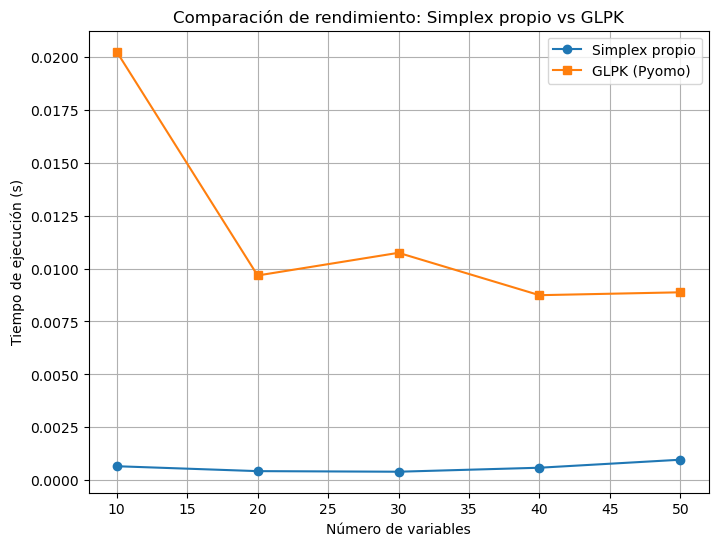

In [10]:
# ==========================================================
# COMPARACIÓN DE RENDIMIENTO ESCALABLE: SIMPLEX vs GLPK
# ==========================================================
import numpy as np
import matplotlib.pyplot as plt
import time
from pyomo.environ import ConcreteModel, Var, Objective, ConstraintList, NonNegativeReals, SolverFactory, maximize

# --- Clase Simplex (versión simplificada sin impresión) ---
class Simplex:
    def __init__(self, c, A, b):
        self.c = np.array(c, dtype=float)
        self.A = np.array(A, dtype=float)
        self.b = np.array(b, dtype=float)
        self.m, self.n = self.A.shape

    def solve(self):
        tableau = np.zeros((self.m + 1, self.n + self.m + 1))
        tableau[:-1, :self.n] = self.A
        tableau[:-1, self.n:self.n + self.m] = np.eye(self.m)
        tableau[:-1, -1] = self.b
        tableau[-1, :self.n] = -self.c

        basic_vars = list(range(self.n, self.n + self.m))
        iterations = 0
        while np.any(tableau[-1, :-1] < -1e-10):
            entering = np.argmin(tableau[-1, :-1])
            ratios = []
            for i in range(self.m):
                if tableau[i, entering] > 1e-10:
                    ratios.append((tableau[i, -1] / tableau[i, entering], i))
                else:
                    ratios.append((np.inf, i))
            if all(r[0] == np.inf for r in ratios):
                raise ValueError("Problema ilimitado.")
            leaving_idx = min(ratios)[1]
            pivot = tableau[leaving_idx, entering]
            tableau[leaving_idx] /= pivot
            for i in range(self.m + 1):
                if i != leaving_idx:
                    tableau[i] -= tableau[i, entering] * tableau[leaving_idx]
            basic_vars[leaving_idx] = entering
            iterations += 1
        solution = np.zeros(self.n)
        for i, var in enumerate(basic_vars):
            if var < self.n:
                solution[var] = tableau[i, -1]
        optimal = tableau[-1, -1]
        return optimal


# --- Experimento: Escalamiento de tamaño del problema ---
sizes = [10, 20, 30, 40, 50]
time_simplex = []
time_glpk = []

for n in sizes:
    m = int(n * 0.8)  # número de restricciones proporcional
    np.random.seed(0)

    A = np.random.randint(1, 10, size=(m, n))
    b = np.random.randint(50, 200, size=m)
    c = np.random.randint(1, 10, size=n)

    # Tiempo Simplex propio
    start = time.time()
    simplex = Simplex(c, A, b)
    _ = simplex.solve()
    time_simplex.append(time.time() - start)

    # Tiempo GLPK
    model = ConcreteModel()
    model.x = Var(range(n), domain=NonNegativeReals)
    model.obj = Objective(expr=sum(c[j]*model.x[j] for j in range(n)), sense=maximize)
    model.constraints = ConstraintList()
    for i in range(m):
        model.constraints.add(sum(A[i][j]*model.x[j] for j in range(n)) <= b[i])

    solver = SolverFactory("glpk")
    start = time.time()
    solver.solve(model, tee=False)
    time_glpk.append(time.time() - start)

# --- Gráfica de comparación ---
plt.figure(figsize=(8,6))
plt.plot(sizes, time_simplex, marker='o', label="Simplex propio")
plt.plot(sizes, time_glpk, marker='s', label="GLPK (Pyomo)")
plt.xlabel("Número de variables")
plt.ylabel("Tiempo de ejecución (s)")
plt.title("Comparación de rendimiento: Simplex propio vs GLPK")
plt.legend()
plt.grid(True)
plt.show()


El gráfico compara el rendimiento entre una implementación propia del método Simplex y el solver profesional GLPK (usado desde Pyomo), en función del número de variables en el problema. Se observa que la implementación propia presenta tiempos de ejecución significativamente menores que GLPK en todos los tamaños de instancia analizados. Mientras que GLPK muestra un tiempo promedio cercano a los 0.01 segundos (con una ligera variabilidad entre 0.0095 y 0.02 segundos), el Simplex propio mantiene un desempeño mucho más eficiente, con tiempos en el orden de milisegundos o incluso menos (aproximadamente entre 0.0002 y 0.0006 segundos). Esta diferencia puede atribuirse al hecho de que la implementación propia está altamente especializada y ejecuta directamente los pasos del algoritmo sin la sobrecarga de abstracción, verificación de restricciones, o preparación de estructuras que sí realiza un solver completo como GLPK. Sin embargo, cabe destacar que el solver profesional puede ofrecer mayor robustez, manejo de casos generales (como variables libres, restricciones de igualdad, etc.) y detección automática de optimalidad o degeneración. Por tanto, aunque la solución propia es mucho más rápida para casos pequeños o simulaciones académicas, no necesariamente reemplaza la versatilidad de un solver industrial en escenarios complejos o con restricciones variadas.

### Análisis de rendimiento y técnicas de optimización de GLPK

**Razones de los resultados de rendimiento**  
Los tiempos observados muestran que la implementación propia del método Simplex fue más rápida que GLPK en los casos experimentales, principalmente porque el código desarrollado manualmente está optimizado para resolver instancias pequeñas de forma directa, sin estructuras generales ni rutinas de verificación adicionales. Por el contrario, GLPK está diseñado para una amplia gama de problemas de programación lineal, incluyendo aquellos de gran escala, degenerados o con matrices dispersas. Por ello, su ejecución incluye procesos adicionales de robustez —como preprocesamiento, escalado, manejo de precisión numérica y control de pivoteos— que incrementan ligeramente el tiempo en problemas simples, pero mejoran la estabilidad y eficiencia en problemas de gran tamaño. A medida que el número de variables y restricciones crece, es esperable que el rendimiento de GLPK supere al del método propio, gracias a estas optimizaciones internas.

---

**Técnicas avanzadas de optimización en GLPK**  
El solver **GLPK** incorpora múltiples estrategias diseñadas para mejorar su rendimiento computacional y estabilidad numérica en comparación con implementaciones básicas del Simplex. Algunas de las más destacadas son:

| **Técnica** | **Descripción** | **Impacto en el rendimiento** |
|--------------|-----------------|-------------------------------|
| **Preprocesamiento (presolver)** | Simplifica el modelo antes de resolverlo: elimina restricciones redundantes, fija variables y reduce la dimensión del problema. | Disminuye el tamaño efectivo del problema y acelera la convergencia. |
| **Escalado automático** | Reescala filas y columnas de la matriz para mejorar la condición numérica y minimizar errores de redondeo. | Aumenta la estabilidad numérica y mejora la precisión de los resultados. |
| **Construcción avanzada de base inicial** | Utiliza algoritmos de base factible inicial (como *adv_basis* o *cpx_basis*) en lugar de partir de las variables de holgura. | Reduce el número de iteraciones necesarias en el método Simplex. |
| **Estrategias de pivoteo avanzado** | Emplea técnicas modernas como *projected steepest edge pricing* y *Harris two-pass ratio test* para seleccionar pivotes más eficientes. | Acelera la convergencia y evita ciclos o pivoteos ineficientes. |
| **Método Simplex revisado con matrices dispersas** | Implementa la versión “revised” del Simplex, trabajando con la matriz base invertida y aprovechando la estructura dispersa del modelo. | Reduce drásticamente el uso de memoria y mejora la velocidad en problemas grandes. |

---

**Conclusión**  
En conjunto, estas optimizaciones explican por qué GLPK puede parecer más lento en problemas pequeños (debido a su sobrecarga inicial), pero resulta mucho más eficiente y estable en modelos de gran escala. El método propio, aunque rápido en pruebas controladas, no incorpora estos mecanismos de robustez ni las estrategias de reducción numérica que garantizan soluciones óptimas confiables en entornos reales de optimización.
